<a href="https://colab.research.google.com/github/aivamx/vchat/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count png files:  304593


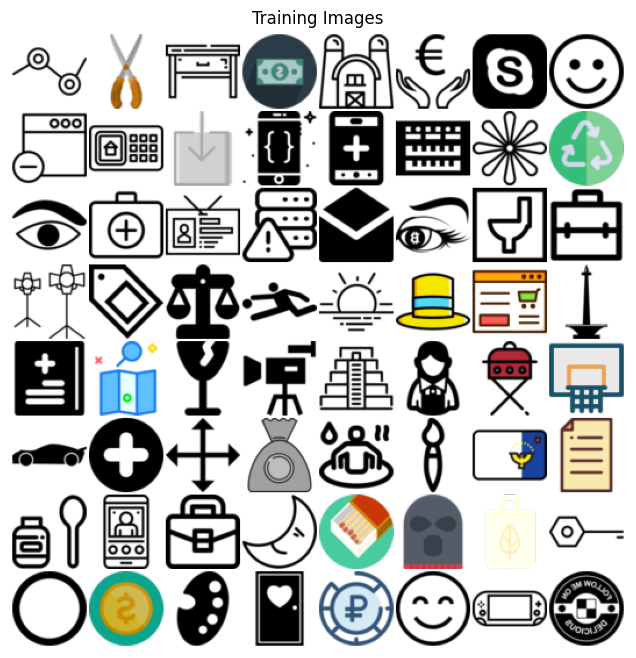

✓ Basic architecture validation passed
Starting Training Loop... start epoch:  4 num epochs:  5
[Epoch 4/5] [Batch 0/4760] Loss D: 0.6197, Loss G: 0.7141 D(x): 0.5869, D(G(z)): 0.5207
[Epoch 4/5] [Batch 50/4760] Loss D: 0.2545, Loss G: 2.2659 D(x): 0.8395, D(G(z)): 0.1187
[Epoch 4/5] [Batch 100/4760] Loss D: 0.3571, Loss G: 2.2145 D(x): 0.8260, D(G(z)): 0.1258
[Epoch 4/5] [Batch 150/4760] Loss D: 0.4276, Loss G: 2.2452 D(x): 0.8454, D(G(z)): 0.1171
[Epoch 4/5] [Batch 200/4760] Loss D: 0.3354, Loss G: 3.1164 D(x): 0.9137, D(G(z)): 0.0504
[Epoch 4/5] [Batch 250/4760] Loss D: 0.3214, Loss G: 2.7109 D(x): 0.9245, D(G(z)): 0.0769
[Epoch 4/5] [Batch 300/4760] Loss D: 0.1997, Loss G: 2.3382 D(x): 0.9005, D(G(z)): 0.1026
[Epoch 4/5] [Batch 350/4760] Loss D: 0.3694, Loss G: 1.4100 D(x): 0.7554, D(G(z)): 0.2606
[Epoch 4/5] [Batch 400/4760] Loss D: 1.3677, Loss G: 0.8115 D(x): 0.4872, D(G(z)): 0.4472
[Epoch 4/5] [Batch 450/4760] Loss D: 0.6815, Loss G: 1.5292 D(x): 0.8383, D(G(z)): 0.2425
[Epoch 

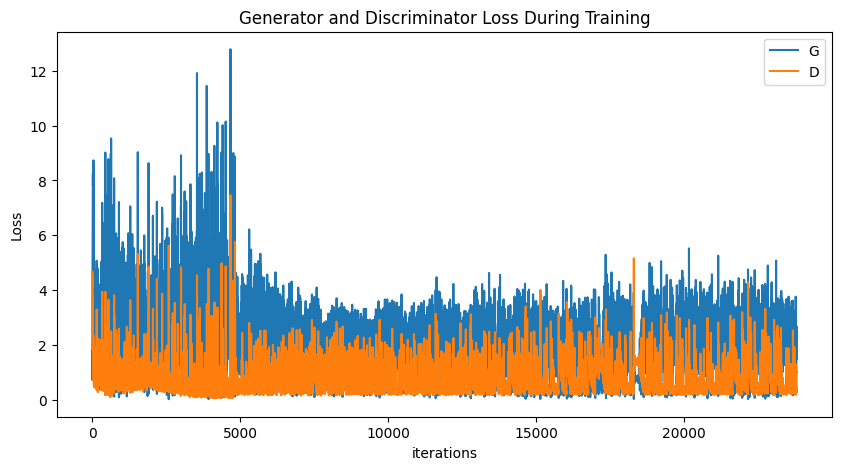

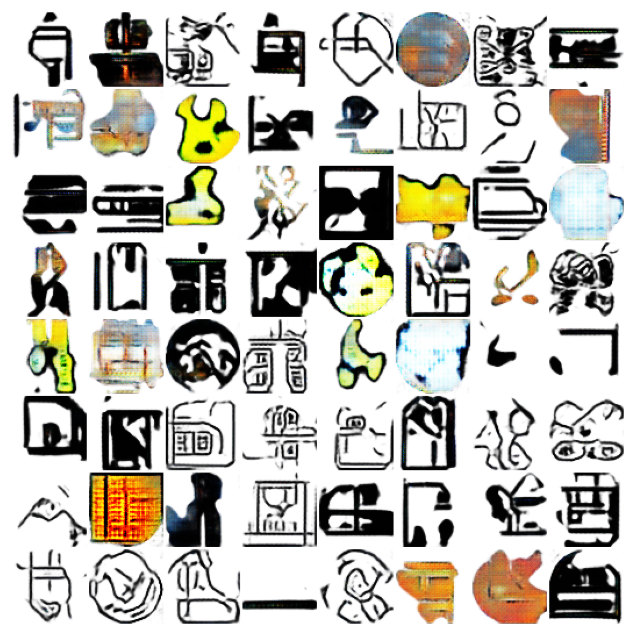

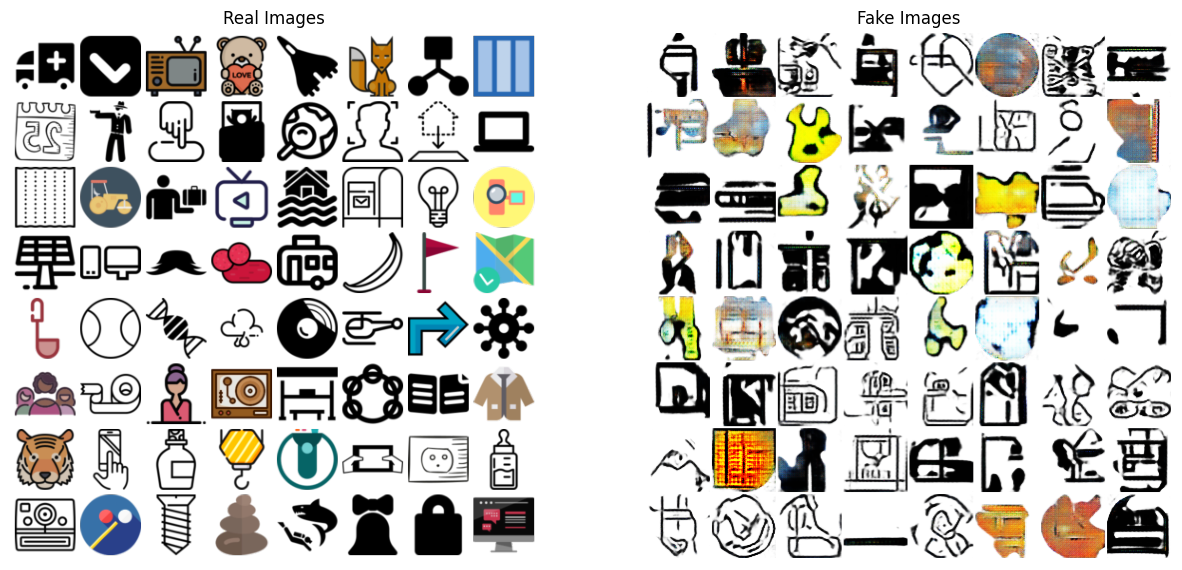

In [12]:
# %matplotlib inline
import argparse
import os
import sys
import glob
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from pathlib import Path

from pathlib import Path
from google.colab import drive

if not Path("data").exists():
    drive.mount("/content/drive")
    os.system("unzip /content/drive/MyDrive/dataset/icons.zip")

print("count png files: ", len(glob.glob("data/*/*.png")))

pth = "/content/drive/MyDrive/dataset/dcgan_checkpoint.pth"

# Оптимизация CUDA (лучше скорость, меньше воспроизводимость)
torch.backends.cudnn.deterministic = False  # Default
torch.backends.cudnn.benchmark = True       # Автоподбор оптимальных алгоритмов

# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 4

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Флаги для управления обновлениями
update_G_twice = False  # Обновлять генератор дважды?
update_D_twice = False # Обновлять дискриминатор дважды?
new_lr_G = 0.0004
new_lr_D = 0.0001

# НАЧАЛО ПОДГОТОВКИ ДАННЫХ

# We can use an image folder dataset the way we have it setup.
# Create the dataset
class RGBAImageDataset(dset.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = Image.open(path).convert("RGBA")
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)
        ),  # Нормализация для 4 каналов
    ]
)

# Create the dataloader
dataset = RGBAImageDataset(root="data", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)
plt.show()

# КОНЕЦ ПОДГОТОВКИ ДАННЫХ


# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == "cuda") and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
# netG.apply(weights_init)

# Print the model
# print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
# print(netD)

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
# criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0003, betas=(beta1, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
start_epoch = 0

def validate_model_loading(netG, netD, checkpoint_path):

    # Загрузка с контролем устройств
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Проверка ключей в чекпоинте
    required_keys = {'generator_state_dict', 'discriminator_state_dict'}
    missing_keys = required_keys - set(checkpoint.keys())
    if missing_keys:
        raise KeyError(f"Missing required keys in checkpoint: {missing_keys}")

    # Валидация архитектуры
    netG_state = netG.state_dict()
    netD_state = netD.state_dict()

    # Проверка совместимости размерностей
    for model, model_name in [(netG_state, 'Generator'), (netD_state, 'Discriminator')]:
        checkpoint_state = checkpoint[f"{model_name.lower()}_state_dict"]
        for key in model:
            if key not in checkpoint_state:
                raise ValueError(f"Key {key} not found in {model_name} checkpoint")
            if model[key].shape != checkpoint_state[key].shape:
                raise ValueError(f"Shape mismatch for {key}: "
                               f"model {model[key].shape} vs "
                               f"checkpoint {checkpoint_state[key].shape}")

    print("✓ Basic architecture validation passed")
    return True

# Загрузка состояния
if Path(pth).exists() and validate_model_loading(netG, netD, pth):
    checkpoint = torch.load(pth)
    netG.load_state_dict(checkpoint["generator_state_dict"])
    netD.load_state_dict(checkpoint["discriminator_state_dict"])
    optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
    optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
    start_epoch = checkpoint["epoch"]
    G_losses = checkpoint["lossG"]
    D_losses = checkpoint["lossD"]

    # Изменение learning rate оптимизатора
    if new_lr_G:
        for param_group in optimizerG.param_groups:
            param_group['lr'] = new_lr_G  # Новый learning rate

    if new_lr_D:
        for param_group in optimizerD.param_groups:
            param_group['lr'] = new_lr_D  # Новый learning rate

    # for param in netG.main[:3].parameters():
    #     param.requires_grad = False

    netG.train()
    netD.train()
else:
    netG.apply(weights_init)
    netD.apply(weights_init)


def train():
    global iters

    try:
        print(
            "Starting Training Loop...",
            "start epoch: ", start_epoch, "num epochs: ", num_epochs)
        # For each epoch
        for epoch in range(start_epoch, num_epochs):
            # For each batch in the dataloader
            for i, (real_images, _) in enumerate(dataloader):
                real_images = real_images.to(device)
                batch_size = real_images.size(0)
                label_real = torch.full((batch_size,), real_label, device=device)
                label_fake = torch.full((batch_size,), fake_label, device=device)

                # ================================================================== #
                #               1. Обновление дискриминатора (netD)                   #
                # ================================================================== #
                num_D_updates = 2 if update_D_twice else 1

                for _ in range(num_D_updates):
                    netD.zero_grad()

                    # Реальные данные
                    output_real = netD(real_images).view(-1)
                    errD_real = criterion(output_real, label_real)
                    errD_real.backward()

                    # Фейковые данные
                    noise = torch.randn(batch_size, nz, 1, 1, device=device)
                    fake_images = netG(noise).detach()  # Отключаем градиенты для G
                    output_fake = netD(fake_images).view(-1)
                    errD_fake = criterion(output_fake, label_fake)
                    errD_fake.backward()

                    errD = errD_real + errD_fake
                    if errD.item() < 0.2:  # Если дискриминатор слишком уверен
                        for param in netD.parameters():
                            param.grad *= 0.5  # Уменьшаем градиенты в 2 раза
                    if errD.item() < 0.2:
                        with torch.no_grad():
                            for param in netD.parameters():
                                if torch.rand(1) < 0.3:  # 30% chance
                                    param *= 0.9  # Ослабляем веса
                    optimizerD.step()

                # ================================================================== #
                #               2. Обновление генератора (netG)                       #
                # ================================================================== #
                num_G_updates = 2 if update_G_twice else 1

                for _ in range(num_G_updates):
                    netG.zero_grad()
                    noise = torch.randn(batch_size, nz, 1, 1, device=device)
                    fake_images = netG(noise)
                    output = netD(fake_images).view(-1)
                    errG = criterion(output, label_real)  # Цель - обмануть D
                    errG.backward()
                    optimizerG.step()

                # ================================================================== #
                #                       3. Логирование и сохранение                  #
                # ================================================================== #
                if i % 50 == 0:
                    print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                        f"Loss D: {errD.item():.4f}, Loss G: {errG.item():.4f} "
                        f"D(x): {output_real.mean().item():.4f}, D(G(z)): {output.mean().item():.4f}")

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
    except KeyboardInterrupt:
        print("Обучение остановлено по сигналу пользователя.")
    finally:
        torch.save(
            {
                "epoch": epoch + 1,  # Сохраняем следующую эпоху
                "generator_state_dict": netG.state_dict(),
                "discriminator_state_dict": netD.state_dict(),
                "optimizerG_state_dict": optimizerG.state_dict(),
                "optimizerD_state_dict": optimizerD.state_dict(),
                "lossG": G_losses,
                "lossD": D_losses,
            }, pth,
        )


    if img_list:
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(8,8))
        plt.axis("off")
        ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
        ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

        HTML(ani.to_jshtml())

        # Grab a batch of real images from the dataloader
        real_batch = next(iter(dataloader))

        # Plot the real images
        plt.figure(figsize=(15,15))
        plt.subplot(1,2,1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

        # Plot the fake images from the last epoch
        plt.subplot(1,2,2)
        plt.axis("off")
        plt.title("Fake Images")
        plt.imshow(np.transpose(img_list[-1],(1,2,0)))
        plt.show()

if __name__ == "__main__":
    train()